In [103]:
import numpy as np
from scipy import stats
from numba import njit
import matplotlib.pyplot as plt

# Create Indicator and MOMENT Functions (First four moments)

In [104]:
@njit
def indicator_func(x,y):
    if x<y:
        return 1
    else:
        return 0
@njit
def get_ev(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=x*px*py*indicator_func(x,y)
    return ev

@njit
def get_ev2(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=(x**2)*px*py*indicator_func(x,y)
    return ev

@njit
def get_ev3(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=(x**3)*px*py*indicator_func(x,y)
    return ev
@njit
def get_ev4(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=(x**4)*px*py*indicator_func(x,y)
    return ev

@njit
def get_skew(EX,EX2,EX3,sigma):
    ans = (EX3 - 3*EX*EX2**2 +3*EX**2*EX- EX**3)/(sigma**3)
    return ans
@njit
def get_kurtosis(EX,EX2,EX3,EX4,sigma):
    ans = (EX4 - 4*EX*EX3 + 6*EX**2*sigma**2 + 3*EX**4)/(sigma**4)
    return ans

# Set up PDFs

In [105]:
timesteps = np.arange(0,10000,1) # Timesteps need to go to infinity
agent_mu,agent_sd = 1000,150 
time_mu,time_sd = 700,150
agent_pdf = stats.norm.pdf(timesteps,agent_mu,agent_sd) # Create Agent pdf
time_pdf = stats.norm.pdf(timesteps,time_mu,time_sd) # Create Timing pdf
prob_x_in_A = stats.norm.cdf(0,agent_mu-time_mu,np.sqrt(agent_sd**2+time_sd**2)) # Get probability of any x being in the new distribution for normalization

# Get the First Four Moments 

In [106]:
EX = get_ev(timesteps,agent_pdf,time_pdf) # First moment
EX_norm = EX/prob_x_in_A # Normalize by prob 

EX2 = get_ev2(timesteps,agent_pdf,time_pdf) # Second moment
EX2_norm = get_ev2(timesteps,agent_pdf,time_pdf)/prob_x_in_A

EX3 = get_ev3(timesteps,agent_pdf,time_pdf)
EX3_norm = EX3/prob_x_in_A

EX4 = get_ev4(timesteps,agent_pdf,time_pdf)
EX4_norm = EX4/prob_x_in_A



# Get variance and sd, skew, and kurtosis

#### $Var(X) = E[X^2] + E[X]^2$

#### $Skew(X) = \frac{E[X^3] - 3 \mu \sigma^2 - \mu^3}{\sigma^3}$

In [107]:
var = EX2_norm - EX_norm**2 # Find the variance
sigma = np.sqrt(var)

skew = get_skew(EX_norm,EX2_norm,EX3_norm,sigma)
kurt = get_kurtosis(EX_norm,EX2_norm,EX3_norm,EX4_norm,sigma)

In [108]:
agent_skew_pdf = stats.skewnorm.pdf(timesteps,0,EX_norm,sigma)

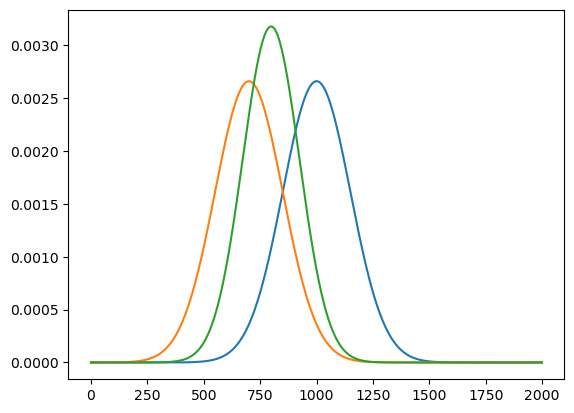

In [109]:
fig,ax = plt.subplots()
ax.plot(agent_pdf[0:2000])
ax.plot(time_pdf[0:2000])
ax.plot(agent_skew_pdf[0:2000])

# Check Work WITH RVS

In [110]:
rvs_x = stats.norm.rvs(agent_mu,agent_sd,1000000)
rvs_y = stats.norm.rvs(time_mu,time_sd,1000000)

mask = rvs_y>rvs_x
prob_included = np.count_nonzero(mask)/1000000
np.nanmean(rvs_x[mask])


802.3721372107252

In [111]:
np.nanstd(rvs_x[mask])

113.67006930183238

In [112]:
np.nanmean(rvs_x[mask])

802.3721372107252

In [113]:
stats.skew(rvs_x*mask)

3.241623465912392

In [114]:
print(stats.kurtosis(rvs_x[mask]))

0.035999388817080646


In [115]:
kurt

9.24061971269451

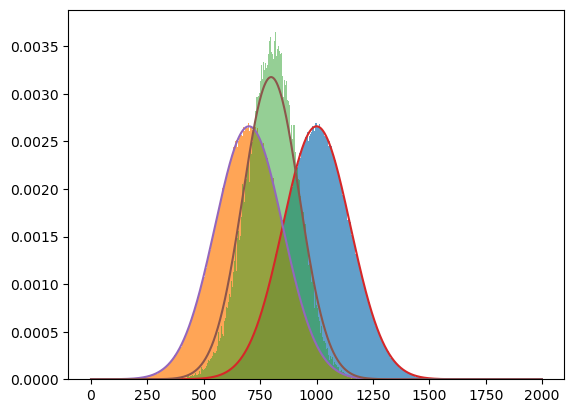

In [116]:
fig,ax = plt.subplots()
ax.hist(rvs_x,bins = 400,density=True,alpha=0.7)
ax.hist(rvs_y,bins = 400,density=True,alpha=0.7)
ax.hist(rvs_x[mask],bins = 400,density=True,alpha=0.5)
ax.plot(agent_pdf[0:2000])
ax.plot(time_pdf[0:2000])
ax.plot(agent_skew_pdf[0:2000])
plt.show()